In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import time
import skimage.io

In [2]:
def make_blob(res, cx, cy, r):
    """
    Parameters
    ----------
    res: int
        Resolution of image
    cx: float
        Center x coordinate in [-1, 1]
    cy: float
        Center y coordinate in [-1, 1]
    r: float
        Radius
    """
    pix = np.linspace(-1, 1, res)
    X, Y = np.meshgrid(pix, pix)
    blob = (X-cx)**2 + (Y-cy)**2 < r**2
    blob = np.array(255*blob, dtype=np.uint8)
    return blob

"""
# Uncomment this to create the dataset
# choose coordinates of blob
n_blobs = 1000
centers = np.random.rand(n_blobs, 2)*2 - 1
r = 0.2
res = 256
np.savetxt("blobs/centers.txt", centers)
for i in range(n_blobs):
    if i%(n_blobs//20) == 0:
        print(".", end='')
    cx, cy = centers[i, :]
    blob = make_blob(res, cx, cy, r)
    skimage.io.imsave("blobs/{}.png".format(i), blob)
"""

'\n# Uncomment this to create the dataset\n# choose coordinates of blob\nn_blobs = 1000\ncenters = np.random.rand(n_blobs, 2)*2 - 1\nr = 0.2\nres = 256\nnp.savetxt("blobs/centers.txt", centers)\nfor i in range(n_blobs):\n    if i%(n_blobs//20) == 0:\n        print(".", end=\'\')\n    cx, cy = centers[i, :]\n    blob = make_blob(res, cx, cy, r)\n    skimage.io.imsave("blobs/{}.png".format(i), blob)\n'

In [3]:
class BlobDataset(Dataset):
    def __init__(self, blob_dir):
        """
        Parameters
        ----------
        blob_dir: string
            Path to directory containing blobs
        """
        self.centers = np.loadtxt("{}/centers.txt".format(blob_dir))
        
    def __len__(self):
        return self.centers.shape[0]
    
    def __getitem__(self, idx):
        img = skimage.io.imread("blobs/{}.png".format(idx))
        img = img.astype(np.float32)/255 # Convert to [0, 1] range 32-bit float
        img = img[None, :, :] # Make this a 1xNxN image so that 
        img = torch.from_numpy(img) # Convert to torch
        label = self.centers[idx, :]
        label = label.astype(np.float32)
        return img, label

In [4]:
class AutoencoderCNN(nn.Module):
    def __init__(self, dim=10):
        """
        Parameters
        ----------
        dim: int
            Dimension of the output
        """
        super(AutoencoderCNN, self).__init__()
        
        ## Step 1: Setup the architecture
        self.dim = dim
        # 1 input channel, 8 output channels, 3x3 convolutional kernel, jump by 2
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv1_relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.conv2_relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.final = nn.Linear(65536, dim)
        self.final_nonlinear = nn.Tanh()
        
        ## Step 2: Setup objective function
        self.criterion = nn.MSELoss() # Like squared euclidean distance
        # Setting up smart backprop, with a "learning rate" (step size) of 0.001 
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001) 
        
    def forward(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu]
        layers += [self.flatten, self.final, self.final_nonlinear]
        y = x
        #print("Input Shape: ", y.shape) 
        for layer in layers:
            y = layer(y)
            #print(y.shape) # Uncomment this to print the shapes again
        return y
    
    def train(self, data_loader, n_epochs=20):
        losses = []
        for epoch in range(n_epochs): # A cycle through all of the data
            tic = time.time()
            train_loss = 0.0
            for imgs, centers in data_loader:
                print(".", end='')
                # images = images.to(device) ## TODO: Get this onto GPU
                self.optimizer.zero_grad() # Reset from last iteration
                centers_est = self.forward(imgs)
                loss = self.criterion(centers_est, centers) # Compute objective function
                # summed over all image centers
                loss.backward() # Backpropagation
                self.optimizer.step()
                train_loss += loss.item() # Keep track of loss 
            losses.append(train_loss)
            toc = time.time()
            print("Epoch {}, Loss = {:.6f}, Elapsed Time {:.3f}".format(epoch, train_loss, toc-tic))
        return losses

model = AutoencoderCNN(2)

dataset = BlobDataset("blobs")
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
losses = model.train(train_dataloader, n_epochs=20)

................Epoch 0, Loss = 5.592756, Elapsed Time 2.095
................Epoch 1, Loss = 0.918262, Elapsed Time 1.817
................Epoch 2, Loss = 0.252088, Elapsed Time 1.765
................Epoch 3, Loss = 0.125254, Elapsed Time 1.766
................Epoch 4, Loss = 0.075567, Elapsed Time 1.767
................Epoch 5, Loss = 0.057419, Elapsed Time 1.769
................Epoch 6, Loss = 0.049295, Elapsed Time 1.766
................Epoch 7, Loss = 0.043525, Elapsed Time 1.777
................Epoch 8, Loss = 0.039728, Elapsed Time 1.765
................Epoch 9, Loss = 0.036490, Elapsed Time 1.767
................Epoch 10, Loss = 0.033637, Elapsed Time 1.778
................Epoch 11, Loss = 0.031830, Elapsed Time 1.782
................Epoch 12, Loss = 0.029641, Elapsed Time 1.779
................Epoch 13, Loss = 0.027845, Elapsed Time 1.778
................Epoch 14, Loss = 0.026095, Elapsed Time 1.779
................Epoch 15, Loss = 0.024626, Elapsed Time 1.765
................Ep

Text(0, 0.5, 'MSE Loss')

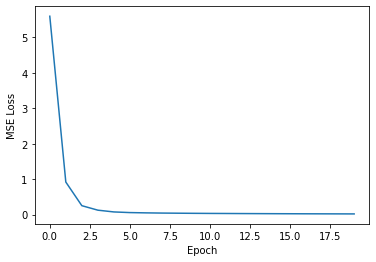

In [5]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

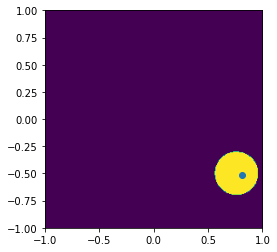

In [19]:
cx = 0.76
cy = -0.5
r = 0.2
res = 256
blob = make_blob(res, cx, cy, r)
blob = np.array(blob, dtype=np.float32)/255

# Put in a batch of 1
blob_tensor = torch.from_numpy(blob[None, None, :, :])
res = model(blob_tensor).detach().numpy() # Take it out of tensorflow back to numpy
res = res.flatten()

plt.imshow(blob, extent=(-1, 1, 1, -1))
plt.scatter(res[0], res[1])
plt.gca().invert_yaxis()

#img, label = dataset[10]
#print(label)
#plt.imshow(img[0, :, :], extent=[-1, 1, 1, -1])
#plt.scatter(label[0], label[1])
